# Audio Recognition using Tensorflow

This approach uses CNN to build a classifier for audio inputs

## Import necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from utils import *
from datetime import datetime
from time import time
from tensorflow.python.client import timeline # for profiling

%matplotlib inline
np.random.seed(1)

## Import the dataset

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_data()

## Explore the dataset

In [3]:
X_train = X_train_orig
X_test = X_test_orig
Y_train = convert_to_one_hot(Y_train_orig, classes)
Y_test = convert_to_one_hot(Y_test_orig, classes)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1000
number of test examples = 60
X_train shape: (1000, 16000, 1, 1)
Y_train shape: (1000, 30)
X_test shape: (60, 16000, 1, 1)
Y_test shape: (60, 30)


## Create input placeholders

Tensorflow placeholders for X and Y. These will be dynamically set during batch G.D at runtime

In [4]:
def create_placeholders(n_l, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_l -- scalar, length of the audio vector
    n_y -- scalar, number of classes

    Returns:
    X -- placeholder for the data input, of shape [None, n_l] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    X = tf.placeholder(tf.float32, shape=(None, n_l, 1, 1), name="X")
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name="Y")

    return X, Y

In [5]:
# X, Y = create_placeholders(500, 20)
# print ("X = " + str(X))
# print ("Y = " + str(Y))

## Initialize Parameters

With tensorflow we only need to initialize parameters for Conv layers. Fully connected layers' paramaters are completed handled by the framework.

In [6]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
    W1 : [4, 1, 1, 8]
    W2 : [2, 1, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """

    tf.set_random_seed(1)

    W1 = tf.get_variable("W1", [4,1,1,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,1,8,16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1, "W2": W2}

    return parameters

In [7]:
# tf.reset_default_graph()
# with tf.Session() as sess_test:
#     parameters = initialize_parameters()
#     init = tf.global_variables_initializer()
#     sess_test.run(init)
#     print("W1 = " + str(parameters["W1"].eval()[0,0,0]))
#     print("W2 = " + str(parameters["W2"].eval()[0,0,0]))

## Forward Propagation

CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

Following are the parameters for all the layers:
    - Conv2D: stride 1, padding is "SAME"
    - ReLU
    - Max pool: 8 by 1 filter size and an 8 by 1 stride, padding is "SAME"
    - Conv2D: stride 1, padding is "SAME"
    - ReLU
    - Max pool: 4 by 1 filter size and a 4 by 1 stride, padding is "SAME"
    - Flatten the previous output.
    - FULLYCONNECTED (FC) layer: outputs 30 classes one for each audio utterance

In [8]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing parameters "W1", "W2"
    the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    W2 = parameters['W2']
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
#     regularizer = None

    Z1 = tf.layers.conv2d(X, 8, (4,1), strides = [1,1], padding = 'SAME', kernel_regularizer = regularizer, name="z1")
    A1 = tf.nn.relu(Z1, name="a1")
    P1 = tf.nn.max_pool(A1, ksize = [1,8,1,1], strides = [1,8,1,1], padding = 'SAME', name="p1")
    Z2 = tf.layers.conv2d(P1, 16, (2, 1), strides = [1,1], padding = 'SAME', kernel_regularizer = regularizer, name="z2")
    A2 = tf.nn.relu(Z2, name="a2")
    P2 = tf.nn.max_pool(A2, ksize = [1,4,1,1], strides = [1,4,1,1], padding = 'SAME', name="p2")
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 30, activation_fn=None, weights_regularizer = regularizer)

    return Z3

In [9]:
# tf.reset_default_graph()
# with tf.Session() as sess:
#     np.random.seed(1)
#     X, Y = create_placeholders(64, 5)
#     parameters = initialize_parameters()
#     Z3 = forward_propagation(X, parameters)
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     a = sess.run(Z3, {X: np.random.randn(2,64,1,1), Y: np.random.randn(2,5)})
#     print("Z3 = " + str(a))

## Compute Cost

Using the last layer Z3, compute softmax and J

In [10]:
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (30, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y, name="L"), name="J")

    return cost

In [11]:
# tf.reset_default_graph()
# with tf.Session() as sess:
#     np.random.seed(1)
#     X, Y = create_placeholders(64, 30)
#     parameters = initialize_parameters()
#     Z3 = forward_propagation(X, parameters)
#     cost = compute_cost(Z3, Y)
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     a = sess.run(cost, {X: np.random.randn(4,64,1,1), Y: np.random.randn(4,30)})
#     print("cost = " + str(a))

## Model

Connects all the functions and sets up training with mini batches

### Start a session

In [12]:
tf.reset_default_graph() # to be able to rerun the model without overwriting tf variables

config = tf.ConfigProto(device_count = {'GPU': 0})

# Start an interactive session
sess = tf.InteractiveSession(config=config)

### Profiling

In [13]:
options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [14]:
def create_model(X_train, Y_train, learning_rate):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X_train -- training set, of shape (None, 16000, 1, 1)
    Y_train -- test set, of shape (None, n_y = 30)
    X_test -- training set, of shape (None, 16000, 1, 1)
    Y_test -- test set, of shape (None, n_y = 30)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    tf.set_random_seed(1) # to keep results consistent (tensorflow seed)
    (m, n_l, _, __) = X_train.shape
    n_y = Y_train.shape[1]

    X, Y = create_placeholders(n_l, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Using AdamOptimizer to minimize the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, name="adam").minimize(cost, name="adam_minimize")

    return Z3, X, Y, parameters, cost, optimizer

In [15]:
def run_model(X_train, Y_train, cost, optimizer, learning_rate = 0.011, minibatch_size = 64, num_epochs = 100, print_cost = True):
    
    seed = 3 # to keep results consistent (numpy seed)
    m = X_train.shape[0]
    num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
    costs = [] # To keep track of the cost
    
    # Run the initialization
    sess.run(tf.global_variables_initializer())
    
    # Do the training loop
    for epoch in range(num_epochs):
        minibatch_cost = 0.
        # print("> epoch = %s, m = %s, mini size = %s, mini cost = %s" % (epoch, m, minibatch_size, minibatch_cost))
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            # print(">> mini X.shape = %s, mini Y.shape = %s" % (minibatch_X.shape, minibatch_Y.shape))
            # IMPORTANT: The line that runs the graph on a minibatch.
            # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
            _ , temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
            # print(">> Temp cost = %s" % temp_cost)
            minibatch_cost += temp_cost / num_minibatches

        # Print the cost every epoch
        if print_cost == True and epoch % 5 == 0:
            print("%s: Cost after epoch %i: %f" % (datetime.now().strftime('%Y-%m-%d %H:%M:%S'), epoch, minibatch_cost))
        if print_cost == True and epoch % 1 == 0:
            costs.append(minibatch_cost)


    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [16]:
Z3, X, Y, parameters, cost, optimizer = create_model(X_train, Y_train, learning_rate = 0.011)

In [17]:
saver = tf.train.Saver() # create a saver for saving variables to disk

2018-01-06 03:54:56: Cost after epoch 0: 4.641669
2018-01-06 03:55:04: Cost after epoch 5: 3.138385
2018-01-06 03:55:11: Cost after epoch 10: 1.342545
2018-01-06 03:55:19: Cost after epoch 15: 0.573443
2018-01-06 03:55:27: Cost after epoch 20: 0.308913
2018-01-06 03:55:34: Cost after epoch 25: 0.301553
2018-01-06 03:55:42: Cost after epoch 30: 0.264971
2018-01-06 03:55:49: Cost after epoch 35: 0.173612
2018-01-06 03:55:57: Cost after epoch 40: 0.192447
2018-01-06 03:56:04: Cost after epoch 45: 0.231477


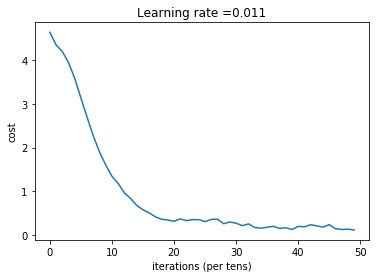

In [18]:
run_model(X_train, Y_train, cost, optimizer, learning_rate = 0.011, minibatch_size = 256, num_epochs = 50)

### Save profiling data to disk

In [19]:
# Create the Timeline object, and write it to a json file
fetched_timeline = timeline.Timeline(run_metadata.step_stats)
chrome_trace = fetched_timeline.generate_chrome_trace_format()
time_id = int(time())
with open('../experiments/timeline_s_256b_120e_gpu0_l2_%s.json' % (time_id,), 'w') as f:
    f.write(chrome_trace)

## Save model to disk

In [20]:
saved_path = saver.save(sess, "../saved_models/trained_model.ckpt")

meta_graph_def = tf.train.export_meta_graph(filename='../saved_models/my-cnn-tf-model.meta')

## Check Model Accuracy

In [21]:
def model_accuracy(X_train, Y_train, Z3, X, Y, minibatch_size = 64, print_progress = True):
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    num_minibatches = 0
    acc_accuracy = 0
    minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
    for minibatch in minibatches:
        (minibatch_X, minibatch_Y) = minibatch
        acc_accuracy += accuracy.eval({X: minibatch_X, Y: minibatch_Y})
        num_minibatches += 1
        
        if num_minibatches % 25 == 0:
            print("%s: Accuracy after %ith batch: %f" % (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), num_minibatches, acc_accuracy / num_minibatches))

    train_accuracy = acc_accuracy / num_minibatches
    print("Accuracy:", train_accuracy)

    return train_accuracy

In [22]:
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [23]:
# train accuracy
model_accuracy(X_train, Y_train, Z3, X, Y, minibatch_size = 256)

('Accuracy:', 0.98905576765537262)


0.98905576765537262

In [24]:
# test accuracy
model_accuracy(X_test, Y_test, Z3, X, Y, minibatch_size = 256)

('Accuracy:', 0.11666666716337204)


0.11666666716337204

## Inference

- Convert audio file to vector and reshape
- Do forward prop
- Find the maximal class
- Remap index to class name

In [25]:
def inference(audio_file, Z3):
    ra = load_wav_file(os.path.abspath(audio_file))
    x = ra.reshape(1, ra.shape[0], 1, 1)
    y_hat = tf.argmax(Z3, 1)
    prediction = sess.run(y_hat, feed_dict = {X: x})
    return classes[prediction[0]]

In [26]:
print(inference("../data/train/audio/bed/0a7c2a8d_nohash_0.wav", Z3)) # bed
print(inference("../data/train/audio/down/0a7c2a8d_nohash_0.wav", Z3)) # down
print(inference("../data/test/audio/clip_0000adecb.wav", Z3)) # happy

four
go
seven


## Load Variables

In [27]:
# saver = tf.train.Saver() # create a saver for saving variables to disk
# saver.restore(sess, "../saved_models/trained_model.ckpt")